# TOLIMAN Toy Model

This is a toy model for the proposed TOLIMAN space telescope, using the ``poppy`` package. Please see [the documentation](http://pythonhosted.org/poppy/) for full details in the API, and the SPIE papers by Perrin et al. ([2012](http://adsabs.harvard.edu/abs/2012SPIE.8442E..3DP), 2014) for further background information and discussion of algorithms. 

This .ipynb is cribbed from the excellent introductory notebook by Marshall Perrin available at http://nbviewer.jupyter.org/github/mperrin/poppy/blob/master/notebooks/POPPY_tutorial.ipynb. We are very grateful for the STSci team's great work on the ``poppy`` package! 

In [1]:
import poppy
import numpy as np
from astropy import *

from __future__ import (absolute_import, division, print_function, unicode_literals)
import scipy.special
import scipy.ndimage.interpolation
import matplotlib
import astropy.io.fits as fits
import astropy.units as u
import warnings
from poppy.poppy_core import OpticalElement, Wavefront, PlaneType, _PUPIL, _IMAGE, _RADIANStoARCSEC
from poppy import utils

import pysynphot as S

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 200             #72 

poppy.__version__

Populating the interactive namespace from numpy and matplotlib


u'0.6.0rc1'

For all of the following examples, you will have more informative text output when running the code if you first enable Python’s logging mechanism to display log messages to screen. This can sometimes be more verbose than is desired, so feel free to turn this on or off as desired. 

In [2]:
import logging
logging.getLogger('poppy').setLevel(logging.WARN)  
#Can be logging.CRITICAL, logging.WARN, logging.INFO, logging.DEBUG for increasingly verbose output

## Define a custom aperture for TOLIMAN

We want to have a non-centro-symmetric rosette of ellipses for TOLIMAN in order to avoid extensive nulls. We therefore need to define both an elliptical aperture, and a composite aperture which sums individual subapertures.

In [3]:

class EllipticalAperture(poppy.AnalyticOpticalElement):
    """ Defines an ideal circular pupil aperture
    Parameters
    ----------
    name : string
        Descriptive name
    radius : float
        Radius of the pupil, in meters. Default is 1.0
    pad_factor : float, optional
        Amount to oversize the wavefront array relative to this pupil.
        This is in practice not very useful, but it provides a straightforward way
        of verifying during code testing that the amount of padding (or size of the circle)
        does not make any numerical difference in the final result.
    """

    @utils.quantity_input(semimajor=u.meter)
    def __init__(self, name=None, semimajor=1.0*u.meter, ecc=0.5, pad_factor=1.0, planetype=PlaneType.unspecified, 
                 **kwargs):

        if name is None:
            name = "Ellipse, a={}, e={}".format(semimajor,ecc)
        super(EllipticalAperture, self).__init__(name=name, planetype=planetype, **kwargs)
        self.semimajor=semimajor
        self.ecc=ecc
        # for creating input wavefronts - let's pad a bit:
        self.pupil_diam = pad_factor * 2 * self.semimajor

    def get_transmission(self, wave):
        """ Compute the transmission inside/outside of the aperture.
        """
        if not isinstance(wave, Wavefront):  # pragma: no cover
            raise ValueError("CircularAperture get_transmission must be called with a Wavefront "
                             "to define the spacing")
        assert (wave.planetype != _IMAGE)

        y, x = self.get_coordinates(wave)
        semimajor = self.semimajor.to(u.meter).value
        semiminor = semimajor*(1.-self.ecc**2.)
        r = np.sqrt((x/semimajor) ** 2 + (y/semiminor) ** 2)
        del x
        del y

        w_outside = np.where(r > 1.)
        del r
        self.transmission = np.ones(wave.shape)
        self.transmission[w_outside] = 0
        return self.transmission


In [4]:
from poppy import AnalyticOpticalElement

In [5]:
class CompositeAnalyticOptic(AnalyticOpticalElement):
    """ Define a compound analytic optical element made up of the combination
    of two or more individual optical elements.
    This is just a convenience routine for semantic organization of optics.
    It can be useful to keep the list of optical planes cleaner, but
    you can certainly just add a whole bunch of planes all in a row without
    using this class to group them.
    All optics should be of the same plane type (pupil or image); propagation between
    different optics contained inside one compound is not supported.
    Parameters
    ----------
    opticslist : list
        A list of AnalyticOpticalElements to be merged together.
    """

    def _validate_only_analytic_optics(self, optics_list):
        for optic in optics_list:
            if isinstance(optic, AnalyticOpticalElement):
                continue  # analytic elements are allowed
            elif isinstance(optic, InverseTransmission):
                if isinstance(optic.uninverted_optic, AnalyticOpticalElement):
                    continue  # inverted elements are allowed, as long as they're analytic elements
                else:
                    return False  # inverted non-analytic elements aren't allowed, skip the rest
            else:
                return False  # no other types allowed, skip the rest of the list
        return True

    def __init__(self, opticslist=None, name="unnamed", verbose=True, **kwargs):
        if opticslist is None:
            raise ValueError("Missing required opticslist argument to CompoundAnalyticOptic")
        AnalyticOpticalElement.__init__(self, name=name, verbose=verbose, **kwargs)

        self.opticslist = []
        self._default_display_size = 3*u.arcsec
        self.planetype = None

        for optic in opticslist:
            if not self._validate_only_analytic_optics(opticslist):
                raise ValueError("Supplied optics list to CompoundAnalyticOptic can "
                                 "only contain AnalyticOptics")
            else:
                # if we are adding the first optic in the list, check what type of optical plane
                # it has
                # for subsequent optics, validate they have the same type
                if len(self.opticslist) == 0:
                    self.planetype = optic.planetype
                elif (self.planetype != optic.planetype and self.planetype != PlaneType.unspecified and
                        optic.planetype != PlaneType.unspecified):
                    raise ValueError("Cannot mix image plane and pupil plane optics in "
                                     "the same CompoundAnalyticOptic")

                self.opticslist.append(optic)
                if hasattr(optic, '_default_display_size'):
                    self._default_display_size = max(self._default_display_size,
                                                     optic._default_display_size)
                if hasattr(optic,'pupil_diam'):
                    if not hasattr(self,'pupil_diam'):
                        self.pupil_diam = optic.pupil_diam
                    else:
                        self.pupil_diam = max(self.pupil_diam, optic.pupil_diam)

        if self.planetype == _PUPIL:
            if all([hasattr(o, 'pupil_diam') for o in self.opticslist]):
                self.pupil_diam = np.asarray([o.pupil_diam.to(u.meter).value for o in self.opticslist]).max() * u.meter

    def get_transmission(self,wave):
        trans = np.zeros(wave.shape, dtype=np.float)
        for optic in self.opticslist:
            trans += optic.get_transmission(wave)
        return trans

    def get_opd(self,wave):
        opd = np.zeros(wave.shape, dtype=np.float)
        for optic in self.opticslist:
            opd += optic.get_opd(wave)
        return opd

    def get_phasor(self, wave):
        phasor = np.zeros(wave.shape, dtype=np.complex)
        for optic in self.opticslist:
            nextphasor = optic.get_phasor(wave)/float(len(self.opticslist))
            phasor += nextphasor
        return phasor

## Now let's generate an example rosette

In [6]:
symm = 5
radius = 0.3 # 30 cm
ecc = 0.8
semimajor = 0.065 # 7.5 cm


aps = []

for j in np.arange(symm):
    pa = 2.*np.pi/symm*(j+1.)
    xc, yc = radius*np.cos(pa), radius*np.sin(pa)
    aps.append(EllipticalAperture(semimajor=semimajor,ecc=ecc,shift_x=xc,shift_y=yc,rotation=180./np.pi*pa,
                                  pad_factor=6))

for j in np.arange(symm):
    pa = 2.*np.pi/symm*(j+1.) + np.pi/symm
    xc, yc = radius*np.cos(pa), radius*np.sin(pa)
    aps.append(EllipticalAperture(semimajor=semimajor,ecc=ecc,shift_x=xc,shift_y=yc,rotation=180./np.pi*pa +90.,
                                  pad_factor=6))

composite = CompositeAnalyticOptic(aps)
composite.name = 'TOLIMAN'

(<matplotlib.axes._subplots.AxesSubplot at 0x10f2b2690>,
 <matplotlib.axes._subplots.AxesSubplot at 0x10b7fc590>)

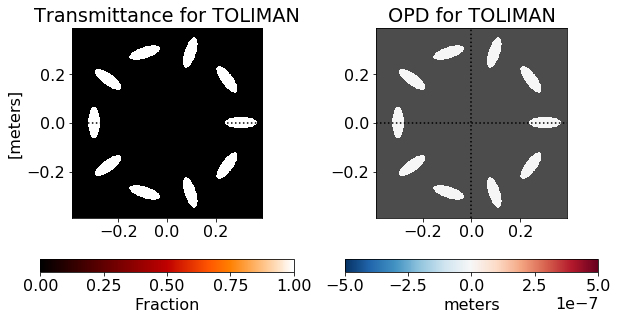

In [7]:
values = composite.sample(npix=2048)    # evaluate on 512 x 512 grid

plt.figure(figsize=(10,5))
composite.display(what='both')         # display phase and amplitude transmission;

## What does the PSF look like?

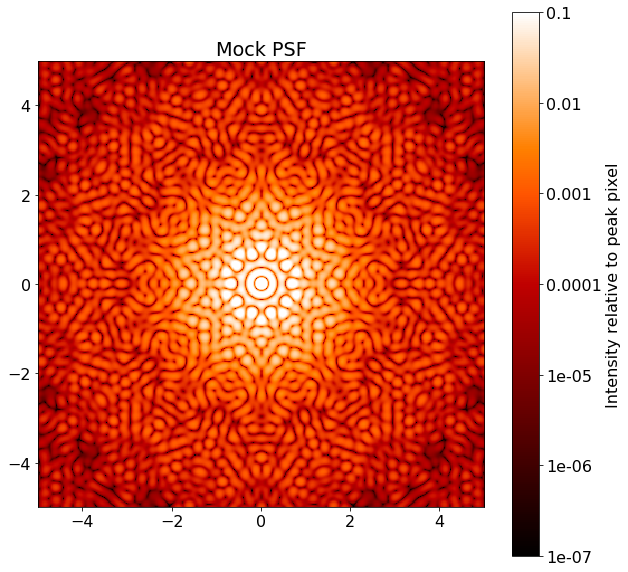

In [8]:
osys = poppy.OpticalSystem()
osys.add_pupil(composite)    # pupil radius in meters
osys.add_detector(pixelscale=0.050, fov_arcsec=10.0)  # image plane coordinates in arcseconds
wavelength=600e-9
psf = osys.calc_psf(wavelength)                            # wavelength in microns
poppy.display_psf(psf, title='Mock PSF',normalize='peak')

In [9]:
# use Phoenix models for Teff, metallicity (dex), log g in that order 

# alpha cen A: Teff = 5790, Z = 0.20, log g = 4.30
acenA = S.Icat('phoenix',5790,0.2,4.30)

# alpha cen B: Teff = 5260, Z = 0.23, log g = 4.37
acenB = S.Icat('phoenix',5260,0.23,4.37)

In [10]:
centre_wavel = 6500
fwhm = 500

# bp = S.ObsBandpass('wfc3,uvis1,f621m')


In [11]:
def supergaussian(wavels,centre,sigma=10,n=8):
    return np.exp(-((wavels-centre)/(sigma/2.))**n)

In [12]:
wavels = np.linspace(centre_wavel-0.75*fwhm,centre_wavel+0.75*fwhm,50)
# bandpass = bp.sample(wavels)
bandpass = supergaussian(wavels,centre_wavel,sigma=fwhm)
specA = acenA.sample(wavels)
specB = acenB.sample(wavels)

source = {'wavelengths':wavels*1e-10,
          'weights':specA*bandpass}

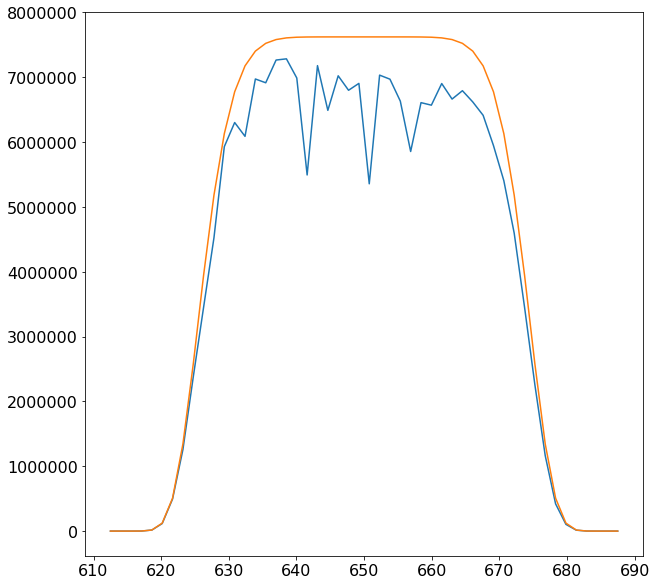

In [13]:
plt.plot(wavels/10.,specA*bandpass)
plt.plot(wavels/10.,np.max(specA)*bandpass)

## Now we want to look at what we can do in the first-order diffraction peak from the doubly-diffractive pupil.

In [14]:
pscale = 0.1 # 100 mas platescale, why not

centre_wavel = 6500
fwhm = 500
nwavels=300

wavels = np.linspace(centre_wavel-0.75*fwhm,centre_wavel+0.75*fwhm,nwavels)
# bandpass = bp.sample(wavels)
bandpass = supergaussian(wavels,centre_wavel,sigma=fwhm)
specA = acenA.sample(wavels)
specB = acenB.sample(wavels)
weights = specA*bandpass
weights = bandpass
weights /= np.max(weights)
source = {'wavelengths':wavels*1e-10,
          'weights':weights}

In [15]:
# we have 2048x2048 array, so let's pick 900 pixels as the diffracted distance

m1 = 900*pscale # this in arcsecs
print(m1)
print(nwavels)

90.0
300


In [16]:
osys = poppy.OpticalSystem()
osys.add_pupil(composite)    # pupil radius in meters
osys.add_detector(pixelscale=pscale, fov_arcsec=20.0)  # image plane coordinates in arcseconds

# psf = osys.calc_psf(source=source)                            # wavelength in microns


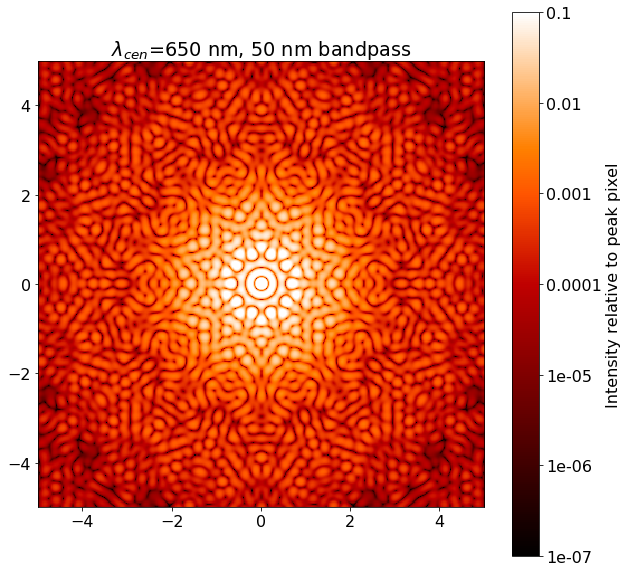

In [17]:
poppy.display_psf(psf, title=r'$\lambda_{cen}$=%.0f nm, %.0f nm bandpass' % (centre_wavel/10.,fwhm/10.),
                  normalize='peak')


In [18]:
broadbandpsf = psf[0].data
nx, ny = broadbandpsf.shape
print(nx)

400


In [208]:
%%time

frames = np.zeros((nx,ny,nwavels))
offsets = []

for j, wavel in enumerate(wavels):
    osys.source_offset_theta = 0
    osys.source_offset_r =  (wavel/centre_wavel -1.)*m1  # arcsec
    offsets.append(osys.source_offset_r)
#     print(osys.source_offset_r)
    frames[:,:,j] = osys.calc_psf(wavel*1e-10)[0].data

offsets = np.array(offsets)

CPU times: user 6min 17s, sys: 1min 27s, total: 7min 45s
Wall time: 6min 17s


In [22]:
nwavels/2

150.0

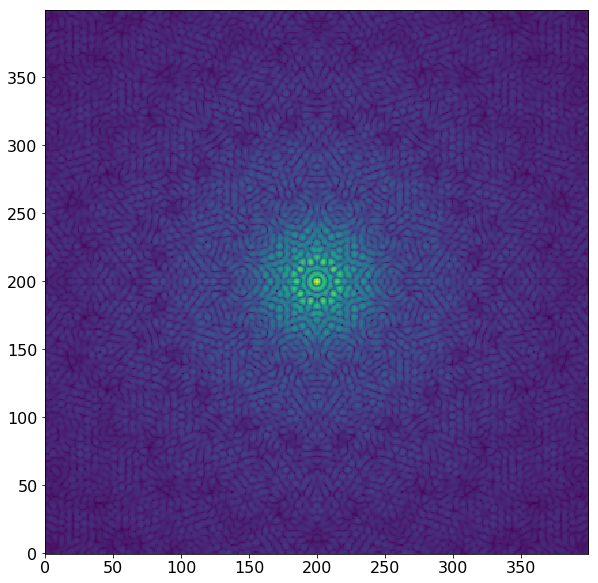

In [23]:
plt.imshow(frames[:,:,int(nwavels/2)]**0.2)

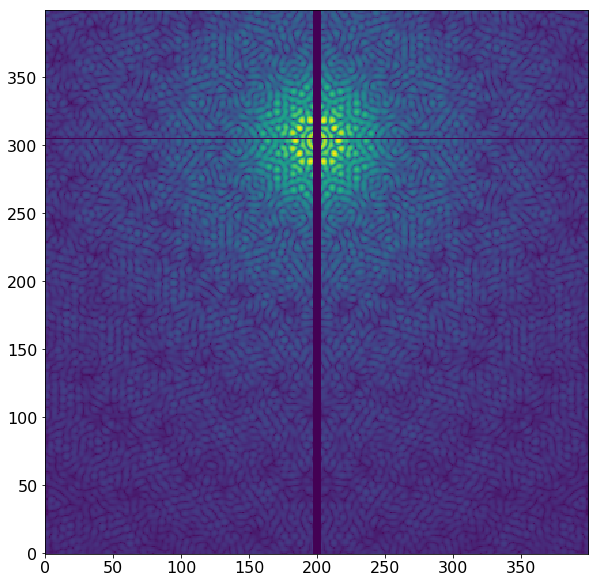

In [24]:
dummy = np.copy(frames)*weights

dummy[:,197:203,:] = 0

dummy[305,:,:] = 0

plt.imshow(dummy[:,:,-1]**0.2)

## Now find their overlap

In [25]:
overlaps = np.zeros(nwavels)

for j in range(nwavels):
    overlaps[j] = np.dot(frames[:,:,j].ravel(),frames[:,:,int(nwavels/2)].ravel())
    


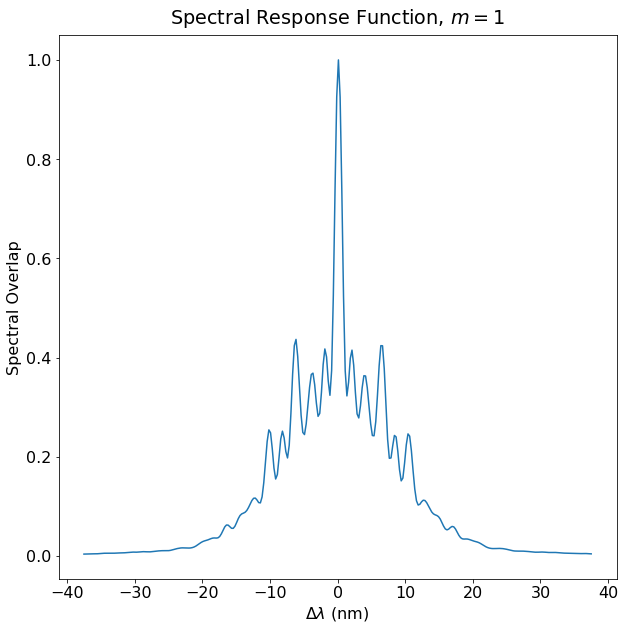

In [92]:
plt.plot((wavels-centre_wavel)/10,overlaps/np.max(overlaps))
plt.xlabel(r'$\Delta \lambda$ (nm)')
plt.ylabel('Overlap Integral')
plt.ylabel('Spectral Overlap')
plt.title(r'Spectral Response Function, $m=1$',y=1.01)
plt.savefig('specresponse.png')

## Now see what the diffraction pattern should look like 

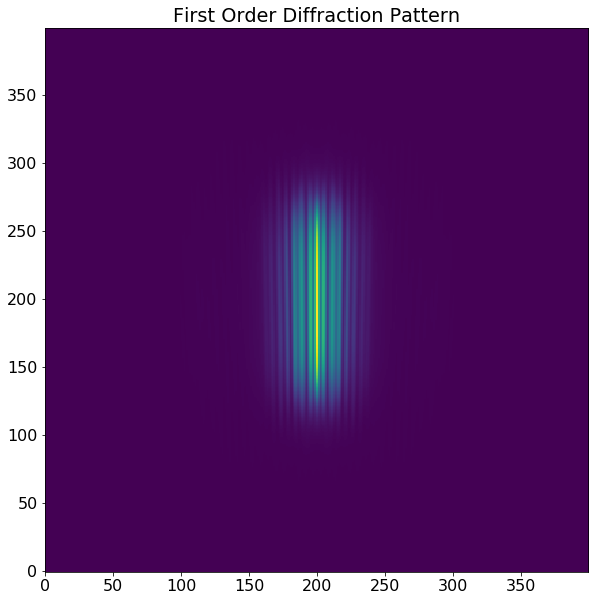

In [27]:
dummy = np.copy(frames)*weights
dummy = dummy.sum(axis=2)
plt.imshow(dummy)
plt.title('First Order Diffraction Pattern')
plt.savefig('firstorder.png')

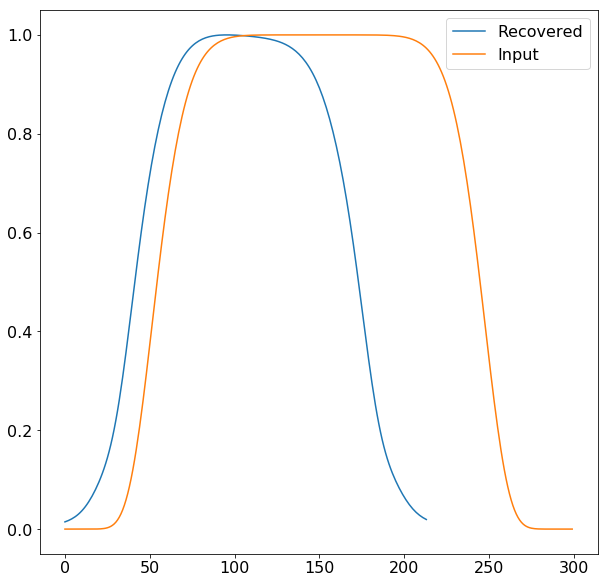

In [28]:
dummy = np.copy(frames)*weights
dummy = dummy.sum(axis=2)

slit = dummy[92:306,197:203]

spectrum = slit.sum(axis=1)
plt.plot(spectrum/np.max(spectrum),label="Recovered")
plt.plot(weights/np.max(weights),label="Input")
plt.legend()

## Now we want to fit the spectrum with least squares using the individual PSFs as a basis

In [29]:
weights = specA*bandpass
# weights = bandpass
weights /= np.max(weights)

dummy = frames*weights

In [30]:
matrix = np.zeros((nx*ny,nwavels))

for j in range(nwavels):
    matrix[:,j] = frames[:,:,j].ravel()#*weights[j]
    matrix[:,j] /= np.max(frames[:,:,j]) # normalize


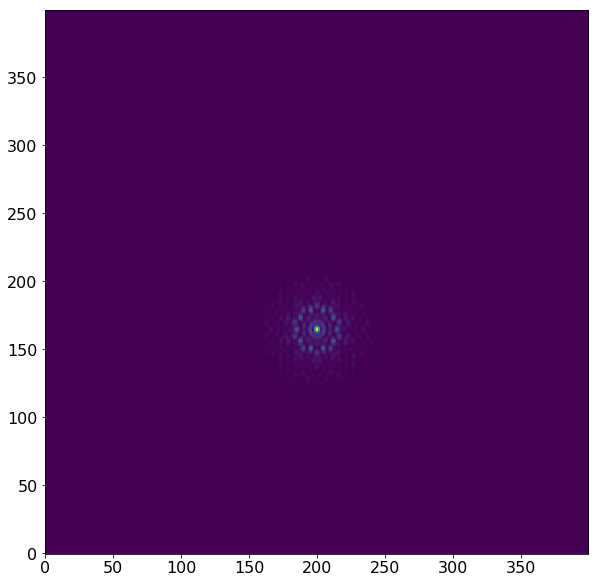

In [31]:
plt.imshow(frames[:,:,98]+frames[:,:,101])

In [32]:
recon = np.zeros(nwavels)
dummy = np.copy(frames)*weights**2
dummy = dummy.sum(axis=2).ravel()

for j in range(nwavels):
    recon[j] = np.dot(dummy,matrix[:,j])
    
dummy = np.reshape(dummy,(nx,ny))

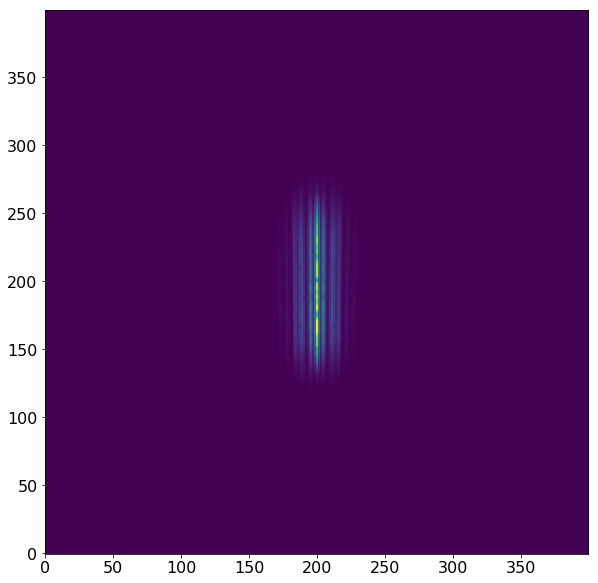

In [33]:
plt.imshow(dummy**2)

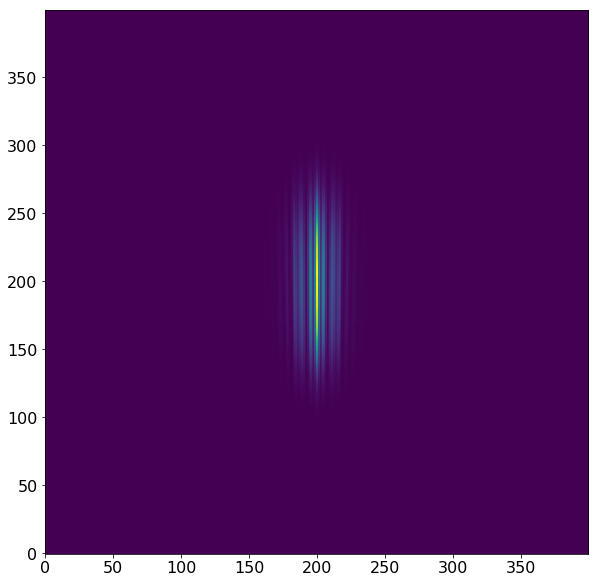

In [35]:
reconimage = np.dot(matrix,recon).reshape((nx,ny))
plt.imshow(reconimage**2)

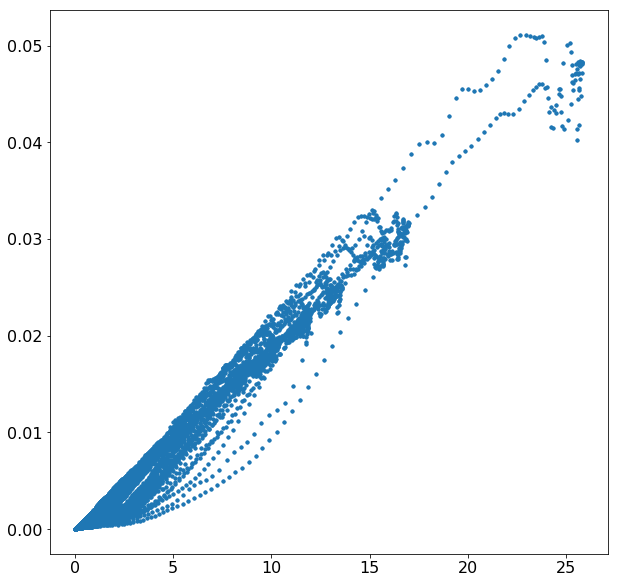

In [36]:
plt.plot(reconimage.ravel(),dummy.ravel(),'.')

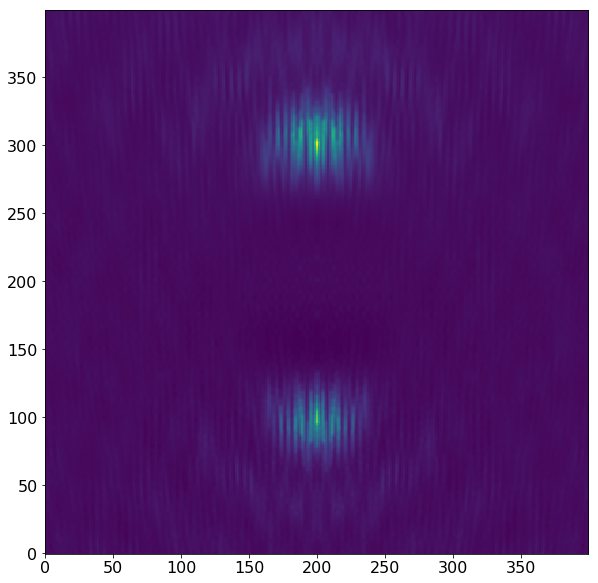

In [37]:
plt.imshow(reconimage/dummy)

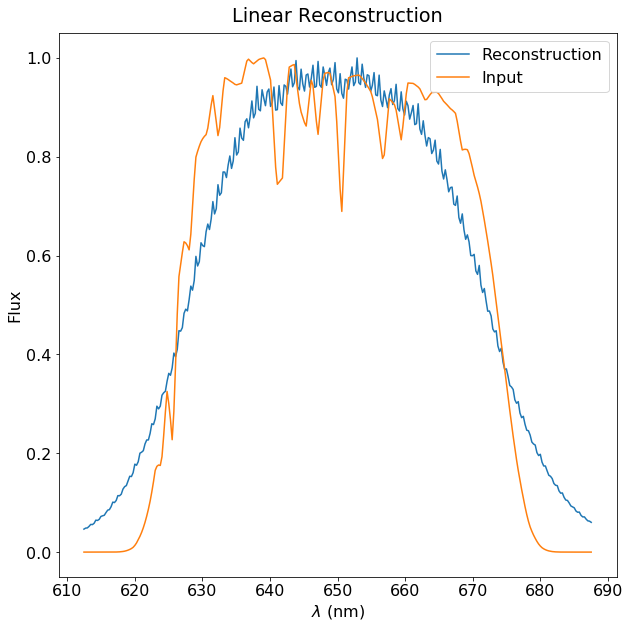

In [58]:
plt.plot(wavels/10.,recon/np.max(recon),label='Reconstruction')
plt.plot(wavels/10.,(weights/np.max(weights)),label='Input')

plt.legend()
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Flux')
plt.title('Linear Reconstruction',y=1.01)

plt.savefig('linear_recon.png')

In [40]:
## find a calibration 
dummy = np.copy(frames)#*weights

dummy = dummy.sum(axis=2).ravel()

calib = np.zeros(nwavels)

for j in range(nwavels):
    calib[j] = np.dot(dummy.ravel(),matrix[:,j])
    
# dummy = np.reshape(dummy,(nx,ny))

In [43]:
# ratio = recon/weights
# # plt.plot(wavels/10.,ratio/ratio.max(),label='Ratio')
# # plt.plot(wavels/10.,(calib/calib.max()),label='Calibration')


# plt.legend()
# plt.xlabel(r'$\lambda$ (nm)')
# plt.ylabel('Flux')
# plt.title('Linear Reconstruction',y=1.01)


In [44]:
np.sum(weights*wavels)/np.sum(weights)

6498.6292266316159

In [45]:
np.sum(recon*wavels)/np.sum(recon)

6500.4790302017209

## Let's try something crazy - can we regularize the spectrum with total variation or MaxEnt?



In [46]:
import scipy.optimize as optimize

import theano
import theano.tensor as T
from theano import pp
from theano import In


So we can see that total variation might be a good regularizer for this spectrum! But which linear combination should we use?

We want to minimize the TV of the spectrum, fitting a linear combination of PSFs from a dictionary. 

So the problem is to minimize chi^2 and the TV of the weights. But I vaguely wonder what the minimum TV spectrum is given just the columns...

In [226]:
def model(w,matrix):
    return np.dot(matrix,w)

def negloglike(w,data,matrix):
    return np.sum((model(w,matrix)-data)**2)

def tv(w):
    v = w/w.sum()
    return np.sum(np.abs(v-np.roll(v,1)))

def entropy(w):
    v = w.sum()
    return np.sum(w/v*np.log(w/v))

def penalty(w,data,matrix):
    return negloglike(w,data,matrix)#+0.001*entropy(w)

In [227]:
for j in range(nwavels):
    frames[:,:,j] /= np.sum(frames[:,:,j])
    matrix[:,j] /= np.sum(matrix[:,j])

In [228]:
%%time
dummy = np.copy(frames)*weights
dummy = dummy.sum(axis=2).ravel()


w_init = np.copy(recon)+ 0.01*np.random.randn(np.size(weights))
w_init/= w_init.sum()
w_init = result['x']

bounds = np.size(weights)*((0,1),)

result = scipy.optimize.minimize(penalty,w_init,args=(dummy.ravel(),matrix),
                                 bounds=bounds,method='SLSQP')

CPU times: user 2min 14s, sys: 1.14 s, total: 2min 15s
Wall time: 45.5 s


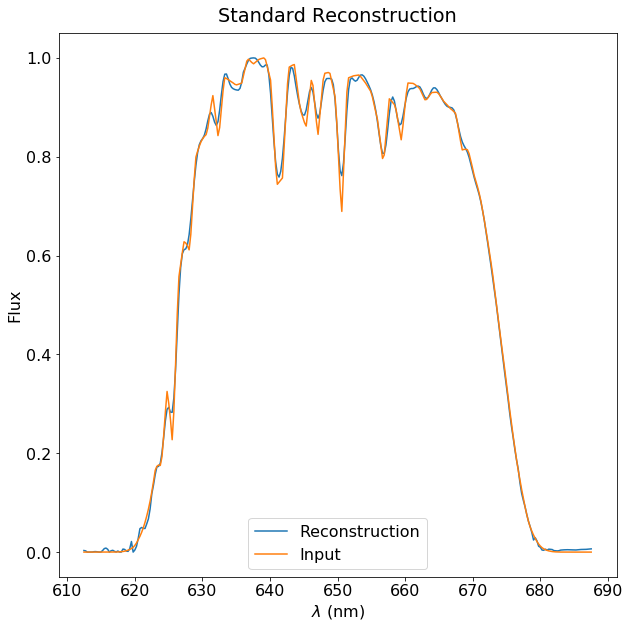

In [229]:
linear_recon = scipy.ndimage.gaussian_filter1d(result['x']/result['x'].max(),0)
linear_recon /= linear_recon.max()
plt.plot(wavels/10.,linear_recon,label='Reconstruction')
plt.plot(wavels/10.,(weights/np.max(weights)),label='Input')
plt.legend()
plt.title('Standard Reconstruction',y=1.01)
plt.xlabel(r'$\lambda$ (nm)')
plt.ylabel('Flux')
plt.savefig('standard_recon.png')

In [230]:
base = np.sum(weights*wavels)/np.sum(weights)
new = np.sum(linear_recon*wavels)/np.sum(linear_recon)
diff = np.abs(new-base)/base*1e6
print(diff,'ppm')

17.8617701387 ppm


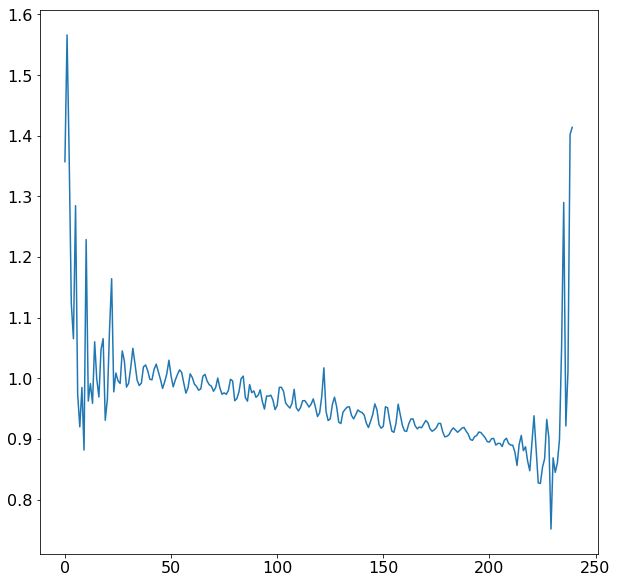

In [153]:
plt.plot(linear_recon[30:-30]/weights[30:-30])

## Richardson-Lucy

In [164]:
from skimage import *
from skimage.restoration import uft

from __future__ import division

import numpy as np
import numpy.random as npr
from scipy.signal import fftconvolve, convolve


def richardson_lucy_1d(image, psf, iterations=50, clip=True):
    direct_time = np.prod(image.shape + psf.shape)

    fft_time =  np.sum([n*np.log(n) for n in image.shape + psf.shape])

    # see whether the fourier transform convolution method or the direct
    # convolution method is faster (discussed in scikit-image PR #1792)
    time_ratio = 40.032 * fft_time / direct_time

    if time_ratio <= 1 or len(image.shape) > 2:
        convolve_method = fftconvolve
    else:
        convolve_method = convolve

    image = image.astype(np.float)
    psf = psf.astype(np.float)
    im_deconv = 0.5 * np.ones(image.shape)
    psf_mirror = psf[::-1]

    for _ in range(iterations):
        relative_blur = image / convolve_method(im_deconv, psf, 'same')
        im_deconv *= convolve_method(relative_blur, psf_mirror, 'same')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    return im_deconv

In [182]:
%%time
psf = overlaps/np.max(overlaps)
im = recon/np.max(recon)

deconvolved = richardson_lucy_1d(im, psf,iterations=200)

CPU times: user 15.2 ms, sys: 742 µs, total: 16 ms
Wall time: 15.3 ms


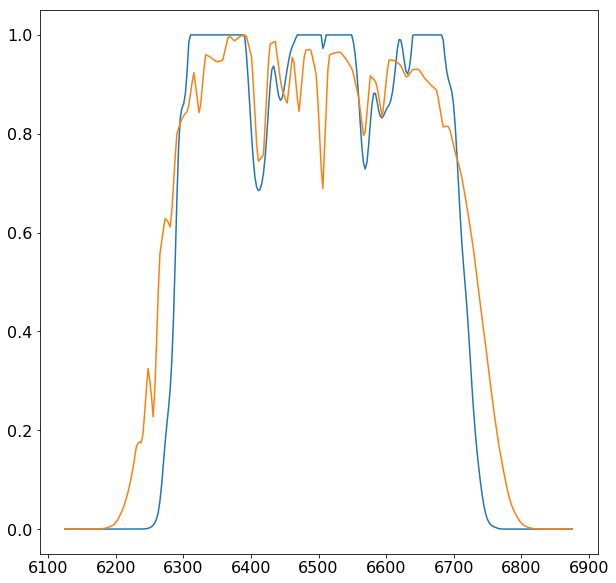

In [183]:
plt.plot(wavels,deconvolved)
plt.plot(wavels,weights)

In [231]:
from skimage.restoration import richardson_lucy

In [257]:
%%time

for j in range(nwavels):
    frames[:,:,j] /= np.sum(frames[:,:,j])
    matrix[:,j] /= np.sum(matrix[:,j])
    
dummy = np.copy(frames)*weights
dummy = dummy.sum(axis=2).ravel()

    
psf = frames[:,:,int(nwavels/2)]
im = dummy.reshape((nx,ny))
deconvolved = richardson_lucy(im, psf,iterations=50)

CPU times: user 6.19 s, sys: 1.33 s, total: 7.51 s
Wall time: 7.56 s


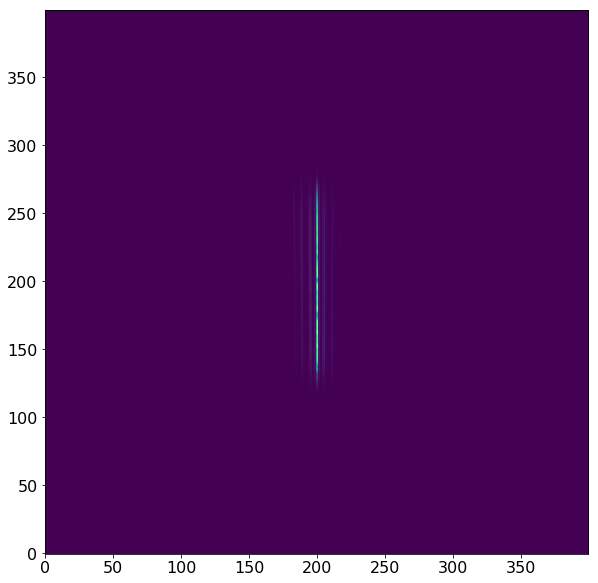

In [258]:
plt.imshow(deconvolved)

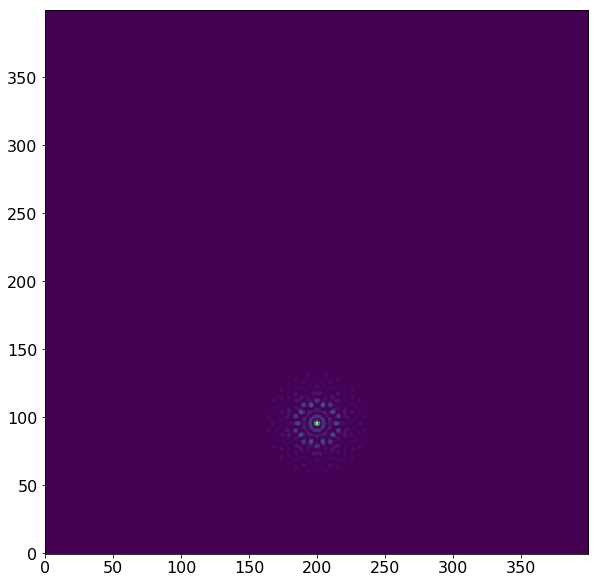

In [251]:
plt.imshow(frames[:,:,0])

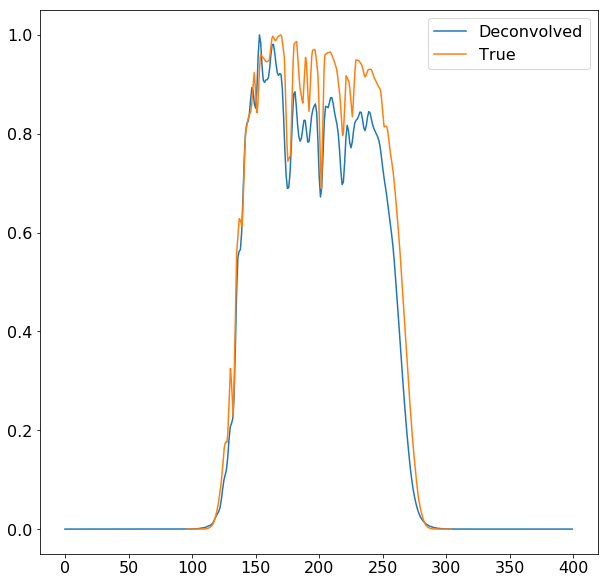

In [252]:
plt.plot(deconvolved[:,200]/deconvolved[:,200].max(),label='Deconvolved')
# plt.plot(im[:,200]/im[:,200].max(),label='Original')
plt.plot(200+2*offsets/pscale,weights/weights.max(),label='True')
plt.legend()